За класифициране на изображения, както е известно, най-добри резултати дава CNN (Convolutional Neural Network) и затова съм избрала да разгледам точно CNN. Малко по-надолу в тетрадката съм представила няколко варианта на CNN:
    - CNN, която съм натренирала за първите пет породи в данните
    - CNN, която съм натренирала за първите десет породи в данните
    - CNN, която класифицира всичките 133 породи, но за да успея да постигна това, и то с добър резултат, съм използвала метода Transfer Learning

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow
import keras.utils as image
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from PIL import ImageFile
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
import zipfile
with zipfile.ZipFile('data/train/train.zip', 'r') as zip_ref:
    zip_ref.extractall('train_5')
with zipfile.ZipFile('data/test/test.zip', 'r') as zip_ref:
    zip_ref.extractall('test_5')
with zipfile.ZipFile('data/valid/valid.zip', 'r') as zip_ref:
    zip_ref.extractall('valid_5')

Горния код служи, както може да се подразбере, за разархивиране на данни и създаването на директории за тях.

In [20]:
train_set_path = './data/train'
test_set_path = './data/test'
valid_set_path = './data/valid'

In [21]:
train_set_path_5 = './train_5'
test_set_path_5 = './test_5'
valid_set_path_5 = './valid_5'

In [22]:
def create_datasets(path, breeds_count):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), breeds_count)
    return dog_files, dog_targets

create_datasets функцията чете файловете на посочения път (path) и ги разпределя на входни данни и класове (labels). Чрез класовете ще проверим колко вярно класифицират моделите. За удобство чрез функцията np_utils.to_categorical() преобразуваме лейбълите във вектор с размер, равен на броя породи, който е съставен от нули и точно една единица, която ни казва каква е породата на съответното куче. Например, ако кучето е от първата категория, то на съответната позиция във вектора ще имаме 1-ца.

In [23]:
X, Y = create_datasets(train_set_path_5, 5)
X_valid, Y_valid = create_datasets(valid_set_path_5, 5)
X_test, Y_test = create_datasets(test_set_path_5, 5)

In [24]:
def path_to_tensor(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  tensor = image.img_to_array(img)
  return np.expand_dims(tensor, axis=0)

def paths_to_tensor(img_paths):
  list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
  return np.vstack(list_of_tensors)

Тъй като Keras очаква 4D масив (тензор) като вход, използваме двете функции path_to_tensor и paths_to_tensor, за да създадем точно такива 4D тензори, които да подадем на CNN. Тези тензори изглеждат така: (1, 224, 224, 3), като първото число съответства на броя снимки, второто и третото са брой редове и колони, а последното са броя цветови канали (тъй като работим със снимки в RGB формат, броят канали е 3).

In [25]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 
train_tensors = paths_to_tensor(X).astype('float32') / 255
valid_tensors = paths_to_tensor(X_valid).astype('float32') / 255
test_tensors = paths_to_tensor(X_test).astype('float32') / 255

Нуждаем се и от предварителна обработка на данните и затова скалираме снимките, като разделим всеки пиксел на всяка снимка на 255.

In [26]:
train_tensors.shape

(314, 224, 224, 3)

In [27]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

Създаваме Sequential модел, който групира всички слоеве на мрежата. Мрежата е съставена от 8 слоя - 3 конволюционни, 3 max pooling, 1 average pooling и 1 dense.
Конволюционните слоеве имат за цел да научат някакви черти (features) от снимките, например нос, очи, уста, като в случая това се случва с матрица (3, 3). Изхода от конволюционните слоеве се подава на max pooling слоевете, които имат за цел в матрица от пиксели с размерност (2, 2) да вземат този пиксел, чиято стойност е най-голяма и да добавят само тази стойност към изхода от слоя. Използваме max pooling слоевете, за да избегнем overfit-ване и да намалим размерността на изхода от конволюционните слоеве. Global average pooling слоя прави подобно нещо на max pooling само че взима средното. Dense слоя получава данни като вход от всички неврони на предишния слой и в случая служи като завършващ слой на мрежата, тоест след него получаваме резултат какво е класифицирала мрежата.

In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.my_model.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, Y, 
          validation_data=(valid_tensors, Y_valid),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 6.9064 - accuracy: 0.2389
Epoch 1: val_loss improved from inf to 6.87223, saving model to saved_models\weights.best.my_model.hdf5
16/16 [==============================] - 6s 298ms/step - loss: 6.9064 - accuracy: 0.2389 - val_loss: 6.8722 - val_accuracy: 0.2308
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 6.6030 - accuracy: 0.2261
Epoch 2: val_loss did not improve from 6.87223
16/16 [==============================] - 4s 272ms/step - loss: 6.6030 - accuracy: 0.2261 - val_loss: 6.8724 - val_accuracy: 0.2308
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 6.6000 - accuracy: 0.2293
Epoch 3: val_loss improved from 6.87223 to 6.87209, saving model to saved_models\weights.best.my_model.hdf5
16/16 [==============================] - 4s 257ms/step - loss: 6.6000 - accuracy: 0.2293 - val_loss: 6.8721 - val_accuracy: 0.2308
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss

Чрез горния код тренираме съставения модел с тренировъчните данни и валидираме с валидиращите данни, като изпълняваме 50 епохи и най-добрия резултат бива записан във файл.

In [30]:
model.load_weights('saved_models/weights.best.my_model.hdf5')

In [47]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
print(f"Accuracy: {accuracy_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 5))*100}%")
print(f"Recall: {recall_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 5), average='weighted', zero_division=1)*100}%")
print(f"Precision: {precision_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 5), average='weighted', zero_division=1)*100}%")
print(f"F1 score: {f1_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 5), average='weighted', zero_division=1)*100}%")

1/1 [==============================] - 0s 14ms/step
Accuracy: 37.5%
Recall: 37.5%
Precision: 64.14596273291926%
F1 score: 30.908602150537632%


Накрая принтираме получените резултати от тестовите данни и можем да забележим, че резултатът не е толкова добър, въпреки че породите, които използваме са само 5 на брой. Според мен, ниският резултат се дължи на това, че всяка една от тези 5 породи разползага със средно около 50 тренировъчни снимки и мрежата не успява да научи достатъчно feature-и и да класифицира по-добре кучетата. Правим абсолютно същите стъпки и за тренирането на CNN с 10 породи:

In [44]:
with zipfile.ZipFile('data/train/train10.zip', 'r') as zip_ref:
    zip_ref.extractall('train_10')
with zipfile.ZipFile('data/test/test10.zip', 'r') as zip_ref:
    zip_ref.extractall('test_10')
with zipfile.ZipFile('data/valid/valid10.zip', 'r') as zip_ref:
    zip_ref.extractall('valid_10')

In [45]:
train_set_path_10 = './train_10'
test_set_path_10 = './test_10'
valid_set_path_10 = './valid_10'

In [48]:
X, Y = create_datasets(train_set_path_10, 10)
X_valid, Y_valid = create_datasets(valid_set_path_10, 10)
X_test, Y_test = create_datasets(test_set_path_10, 10)

In [49]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
train_tensors = paths_to_tensor(X).astype('float32') / 255
valid_tensors = paths_to_tensor(X_valid).astype('float32') / 255
test_tensors = paths_to_tensor(X_test).astype('float32') / 255

In [50]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='relu'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 64)      

In [51]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.my_model_10.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, Y, 
          validation_data=(valid_tensors, Y_valid),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 8.1194 - accuracy: 0.0986
Epoch 1: val_loss improved from inf to 8.26613, saving model to saved_models\weights.best.my_model_10.hdf5
29/29 [==============================] - 11s 311ms/step - loss: 8.1194 - accuracy: 0.0986 - val_loss: 8.2661 - val_accuracy: 0.1127
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 7.6337 - accuracy: 0.0917
Epoch 2: val_loss improved from 8.26613 to 6.93199, saving model to saved_models\weights.best.my_model_10.hdf5
29/29 [==============================] - 8s 259ms/step - loss: 7.6337 - accuracy: 0.0917 - val_loss: 6.9320 - val_accuracy: 0.0845
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 6.9727 - accuracy: 0.1038
Epoch 3: val_loss did not improve from 6.93199
29/29 [==============================] - 7s 256ms/step - loss: 6.9727 - accuracy: 0.1038 - val_loss: 6.9385 - val_accuracy: 0.1127
Epoch 4/50
29/29 [==============================] - ETA: 0s

In [53]:
model.load_weights('saved_models/weights.best.my_model_10.hdf5')

In [56]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
print(f"Accuracy: {accuracy_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 10))*100}%")
print(f"Recall: {recall_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 10), average='weighted', zero_division=1)*100}%")
print(f"Precision: {precision_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 10), average='weighted', zero_division=1)*100}%")
print(f"F1 score: {f1_score(Y_test, np_utils.to_categorical(dog_breed_predictions, 10), average='weighted', zero_division=1)*100}%")

1/1 [==============================] - 0s 16ms/step
Accuracy: 19.17808219178082%
Recall: 19.17808219178082%
Precision: 36.66824122185483%
F1 score: 12.215320910973086%


За съжаление, резултатите са още по-ниски от тези на мрежата за 5 породи, което отново показва, че наличието на повече породи затруднява модела и влошава метриките.
Има начин да получим и добър резултат с данните, които имаме налични и той е като използваме метода Transfer learning. Нарича се Transfer learning, защото използваме предварително добре натрениран модел върху голям брой снимки. Избрала съм модела ResNet50. Добавяме и два слоя към претренирания модел.

In [57]:
X, Y = create_datasets(train_set_path, 133)
X_valid, Y_valid = create_datasets(valid_set_path, 133)
X_test, Y_test = create_datasets(test_set_path, 133)

In [59]:
Resnet50_bottleneck_features = np.load('./DogResnet50Data.npz')
train_Resnet50 = Resnet50_bottleneck_features['train']
valid_Resnet50 = Resnet50_bottleneck_features['valid']
test_Resnet50 = Resnet50_bottleneck_features['test']

In [60]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [61]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [62]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, Y, 
          validation_data=(valid_Resnet50, Y_valid),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
327/334 [============================>.] - ETA: 0s - loss: 1.6296 - accuracy: 0.5963
Epoch 1: val_loss improved from inf to 0.77463, saving model to saved_models\weights.best.Resnet50.hdf5
334/334 [==============================] - 3s 5ms/step - loss: 1.6161 - accuracy: 0.5987 - val_loss: 0.7746 - val_accuracy: 0.7689
Epoch 2/20
317/334 [===========================>..] - ETA: 0s - loss: 0.4398 - accuracy: 0.8637
Epoch 2: val_loss improved from 0.77463 to 0.73950, saving model to saved_models\weights.best.Resnet50.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.4349 - accuracy: 0.8642 - val_loss: 0.7395 - val_accuracy: 0.7725
Epoch 3/20
332/334 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.9169
Epoch 3: val_loss improved from 0.73950 to 0.70842, saving model to saved_models\weights.best.Resnet50.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.2606 - accuracy: 0.9162 - val_loss: 0.7084 - val_accuracy: 0.7725

In [63]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [65]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
print(f"Accuracy: {accuracy_score(Y_test, np_utils.to_categorical(Resnet50_predictions, 133))*100}%")
print(f"Recall: {recall_score(Y_test, np_utils.to_categorical(Resnet50_predictions, 133), average='weighted', zero_division=1)*100}%")
print(f"Precision: {precision_score(Y_test, np_utils.to_categorical(Resnet50_predictions, 133), average='weighted', zero_division=1)*100}%")
print(f"F1 score: {f1_score(Y_test, np_utils.to_categorical(Resnet50_predictions, 133), average='weighted', zero_division=1)*100}%")

1/1 [==============================] - 0s 16ms/step
Accuracy: 82.17703349282297%
Recall: 82.17703349282297%
Precision: 85.54294555789771%
F1 score: 81.90072326923996%


Разбира се, резултатите на тестовите данни са доста по-добри с претренирания модел.

In [66]:
results = [
    [5, 30.91],
    [10, 12.22],
    [133, 81.90]
]

df = pd.DataFrame(results, columns=['Number of breeds', 'F1 score'])
df

,Number of breeds,F1 score
0,5,30.91
1,10,12.22
2,133,81.90


<Figure size 600x400 with 0 Axes>

Text(0.5, 0, 'Number of  breeds')

Text(0, 0.5, 'F1 score')

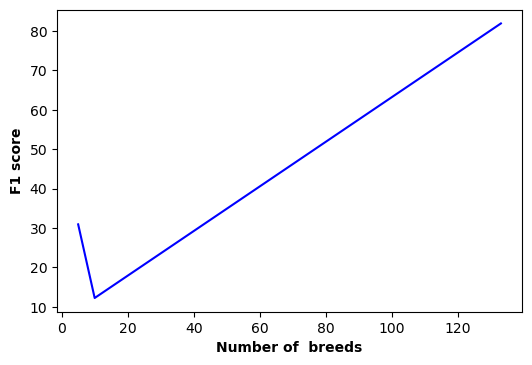

In [69]:
plt.figure(dpi=100)
plt.xlabel("Number of  breeds", fontweight="bold")
plt.ylabel("F1 score", fontweight="bold")
plt.plot(df['Number of breeds'], df['F1 score'], color="blue")
plt.show()

И за финал, диаграмата показва разликата между f1 score-овете на разгледаните модели.